# Cat vs. Dog Image Classification
## Exercise 1: Building a Convnet from Scratch
**_Estimated completion time: 20 minutes_**

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
# !mkdir tmp
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O ./tmp/cats_and_dogs_filtered.zip

In [2]:
import os
import zipfile

local_zip = './tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [3]:
base_dir = './tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.437.jpg', 'cat.186.jpg', 'cat.48.jpg', 'cat.70.jpg', 'cat.534.jpg', 'cat.181.jpg', 'cat.343.jpg', 'cat.509.jpg', 'cat.184.jpg', 'cat.158.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

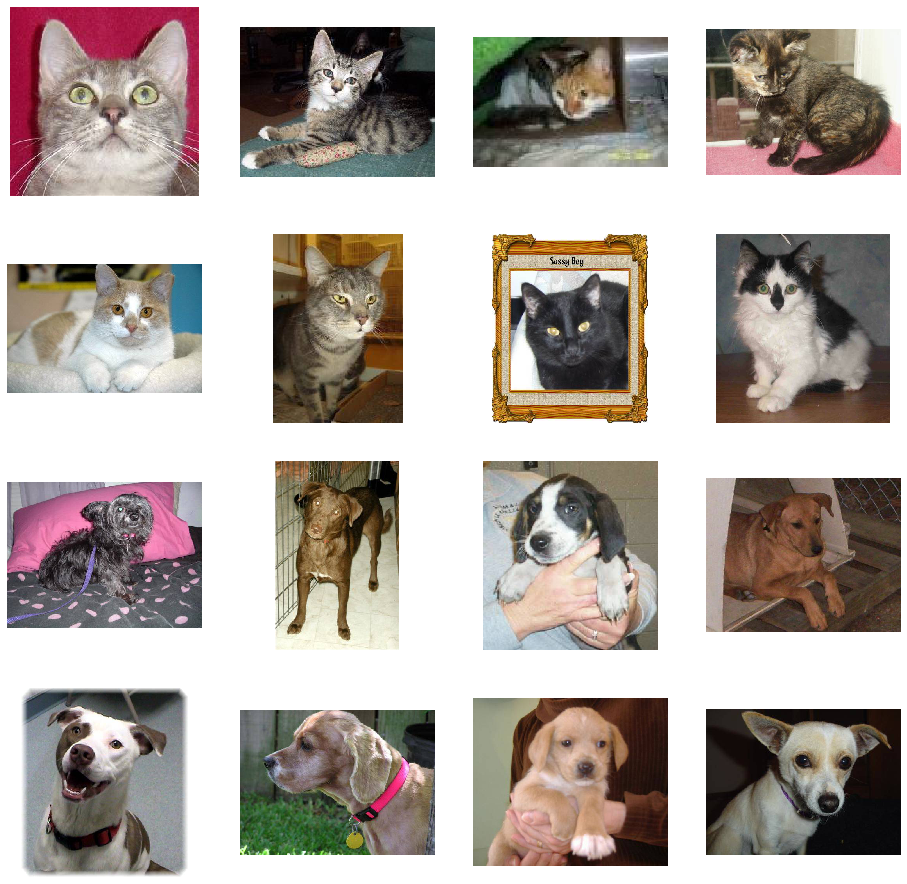

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Convnet from Scratch to Get to 72% Accuracy

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2.)

In [8]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder, DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 150, 150] 
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 0),  # [16, 148, 148]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(16, 32, 3, 1, 0), # [128, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]
            
            nn.Conv2d(32, 64, 3, 1, 0), # [128, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

        )
        self.fc = nn.Sequential(
            nn.Flatten(),             
            nn.Linear(64*17*17, 512),  
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()        # 表示第i个样本的经过sigmoid的预测概率   
        )

    def forward(self, x):
        out = self.cnn(x)
        # out = out.view(out.size()[0], -1)
        out = self.fc(out)
        # out = out.view(-1)
        return out
    
model = Classifier().to(device)    

Let's summarize the model architecture:

In [10]:
model

from torchinfo import summary
summary(model, input_size=(15, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               --                        --
├─Sequential: 1-1                        [15, 64, 17, 17]          --
│    └─Conv2d: 2-1                       [15, 16, 148, 148]        448
│    └─ReLU: 2-2                         [15, 16, 148, 148]        --
│    └─MaxPool2d: 2-3                    [15, 16, 74, 74]          --
│    └─Conv2d: 2-4                       [15, 32, 72, 72]          4,640
│    └─ReLU: 2-5                         [15, 32, 72, 72]          --
│    └─MaxPool2d: 2-6                    [15, 32, 36, 36]          --
│    └─Conv2d: 2-7                       [15, 64, 34, 34]          18,496
│    └─ReLU: 2-8                         [15, 64, 34, 34]          --
│    └─MaxPool2d: 2-9                    [15, 64, 17, 17]          --
├─Sequential: 1-2                        [15, 1]                   --
│    └─Flatten: 2-10                     [15, 18496]               --
│    └─

In [11]:
train_dir
validation_dir

'./tmp/cats_and_dogs_filtered/validation'

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [12]:
test_tfm = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
])

train_set = ImageFolder(root=train_dir, transform = test_tfm)
val_set = ImageFolder(root=validation_dir, transform = test_tfm)

{'cats': 0, 'dogs': 1}
0


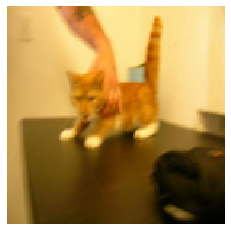

In [13]:
print(train_set.class_to_idx)
print(train_set[0][1])

to_img = transforms.ToPILImage()
a = to_img(train_set[0][0]*0.2+0.4)
plt.imshow(a)
plt.axis("off")
plt.show()

In [14]:
batch_size=20
# The following variables are the hyperparameters.
learning_rate = 0.001
n_epochs = 15

In [15]:
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(val_set,batch_size=batch_size,shuffle=True)

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

## [五分鐘理解：BCELoss 和BCEWithLogitsLoss的區別](https://cloud.tencent.com/developer/article/1660961)
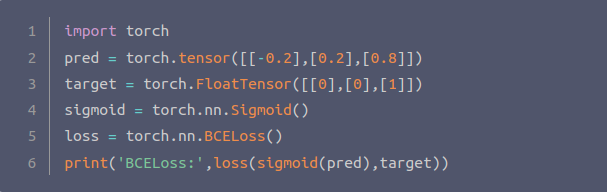

## Computing Model Accuracy
    loop each data item
      get item predictor input values
      get item target value (0 or 1)
      use inputs to compute output value
      if target == 0 and computed output < 0.5
        correct prediction
      else if target == 1 and computed output >= 0.5
        correct prediction
      else
        wrong prediction
    end-loop
    return num correct / (num correct + num wrong)

In [16]:
from torch.autograd import Variable

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

loss_func = nn.BCELoss() 
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_train_acc = []

epoch_valid_acc = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch 
        # print(X.shape) # torch.Size([5, 3, 150, 150])
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device)
        y_hat = model(X)       
        
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y)
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accs = sum(train_accs) / len(train_accs)
    
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accs)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device) 
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y) 
        
        valid_accs.append(acc)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accs = sum(valid_accs) / len(valid_accs)
    epoch_valid_loss.append(valid_loss)
    epoch_valid_acc.append(valid_accs)
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} accuracy = {train_accs:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accs:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/015 ]           train_loss = 1.36597 accuracy = 0.56500  |           valid_loss = 0.66342 val_accuracy = 0.60100



[ Epoch | 002/015 ]           train_loss = 0.64631 accuracy = 0.61850  |           valid_loss = 0.63026 val_accuracy = 0.65200



[ Epoch | 003/015 ]           train_loss = 0.55966 accuracy = 0.71200  |           valid_loss = 0.54342 val_accuracy = 0.71700



[ Epoch | 004/015 ]           train_loss = 0.47307 accuracy = 0.77900  |           valid_loss = 0.58000 val_accuracy = 0.69500



[ Epoch | 005/015 ]           train_loss = 0.39031 accuracy = 0.81400  |           valid_loss = 0.54012 val_accuracy = 0.73300



[ Epoch | 006/015 ]           train_loss = 0.30268 accuracy = 0.86900  |           valid_loss = 0.59319 val_accuracy = 0.72600



[ Epoch | 007/015 ]           train_loss = 0.19820 accuracy = 0.92450  |           valid_loss = 0.65732 val_accuracy = 0.73500



[ Epoch | 008/015 ]           train_loss = 0.11040 accuracy = 0.96050  |           valid_loss = 0.76891 val_accuracy = 0.73600



[ Epoch | 009/015 ]           train_loss = 0.06242 accuracy = 0.97800  |           valid_loss = 0.96696 val_accuracy = 0.73000



[ Epoch | 010/015 ]           train_loss = 0.02414 accuracy = 0.99400  |           valid_loss = 1.27111 val_accuracy = 0.73600



[ Epoch | 011/015 ]           train_loss = 0.09838 accuracy = 0.98000  |           valid_loss = 0.92057 val_accuracy = 0.70500



[ Epoch | 012/015 ]           train_loss = 0.02256 accuracy = 0.99450  |           valid_loss = 1.50940 val_accuracy = 0.72500



[ Epoch | 013/015 ]           train_loss = 0.02394 accuracy = 0.99350  |           valid_loss = 1.52700 val_accuracy = 0.70600



[ Epoch | 014/015 ]           train_loss = 0.03663 accuracy = 0.99150  |           valid_loss = 1.54568 val_accuracy = 0.73100



[ Epoch | 015/015 ]           train_loss = 0.00331 accuracy = 0.99950  |           valid_loss = 1.91917 val_accuracy = 0.73400
Defined the build_model and train_model functions.


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

[如何取得PyTorch模型中特定Layer的輸出？](https://yanwei-liu.medium.com/pytorch-get-output-from-specific-neural-net-layer-with-register-forward-hook-85b41128f75d)

In [17]:
import numpy as np
import random
from PIL import Image

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = Image.open(img_path).resize((150, 150))

x = np.array(img)  # Numpy array with shape (150, 150, 3)

trans = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
])

x = trans(x).unsqueeze(0).to(device) 

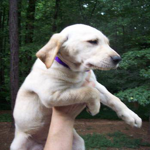

In [18]:
img

In [19]:
x.shape

torch.Size([1, 3, 150, 150])

In [20]:
y_hat = model(x)
y_hat

tensor([[0.0124]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [21]:
# 保存所有layer的output
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
    
output = model(x)
for key in activation:
    print(key)
    print(activation[key].shape)    

cnn.0
torch.Size([1, 16, 148, 148])
cnn.1
torch.Size([1, 16, 148, 148])
cnn.2
torch.Size([1, 16, 74, 74])
cnn.3
torch.Size([1, 32, 72, 72])
cnn.4
torch.Size([1, 32, 72, 72])
cnn.5
torch.Size([1, 32, 36, 36])
cnn.6
torch.Size([1, 64, 34, 34])
cnn.7
torch.Size([1, 64, 34, 34])
cnn.8
torch.Size([1, 64, 17, 17])
cnn
torch.Size([1, 64, 17, 17])
fc.0
torch.Size([1, 18496])
fc.1
torch.Size([1, 512])
fc.2
torch.Size([1, 512])
fc.3
torch.Size([1, 1])
fc.4
torch.Size([1, 1])
fc
torch.Size([1, 1])

torch.Size([1, 1])


n_features: 16
n_features: 16
n_features: 16
n_features: 32
n_features: 32
n_features: 32
n_features: 64
n_features: 64
n_features: 64
n_features: 64


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


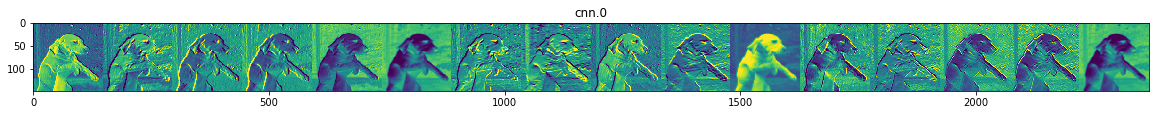

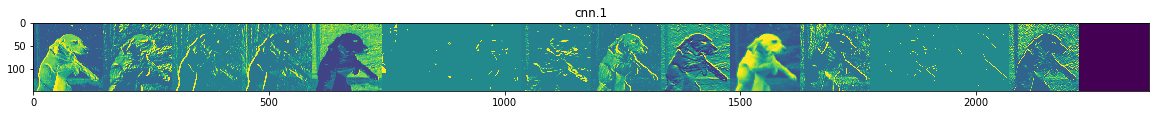

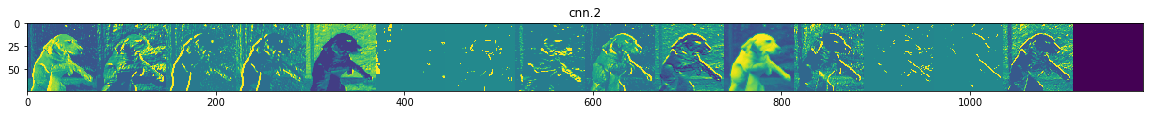

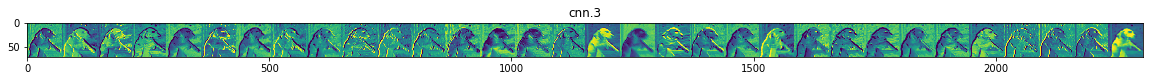

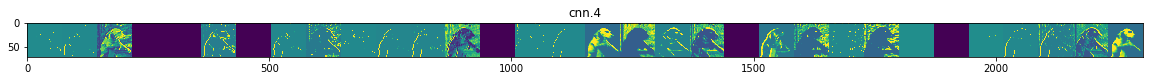

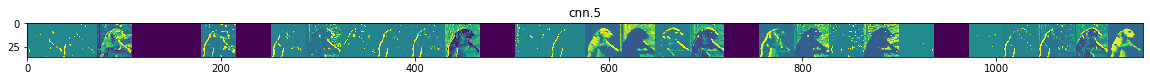

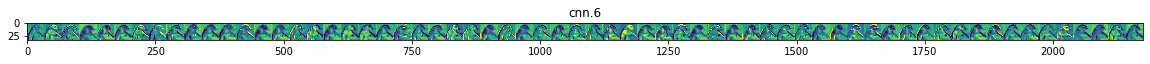

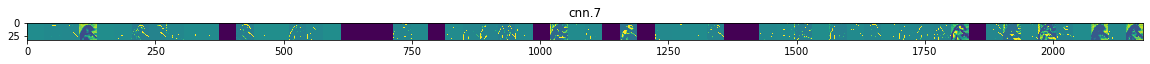

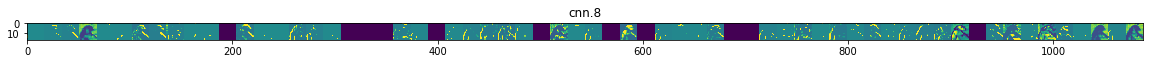

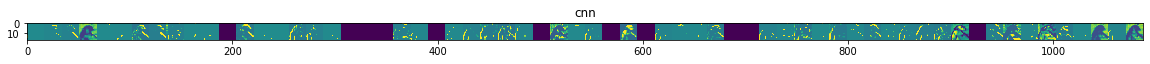

In [22]:
# Now let's display our representations
# for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
for layer_name in activation:
    feature_map = activation[layer_name]
    # print(feature_map.shape)  
    
    if len(feature_map.shape) == 4:
        feature_map = feature_map.cpu().permute(0,2,3,1).numpy()
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        print(f"n_features: {n_features}")
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

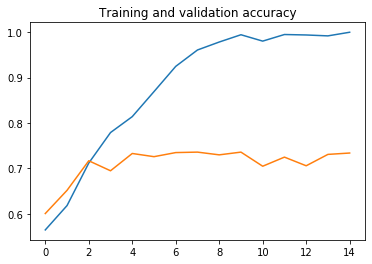

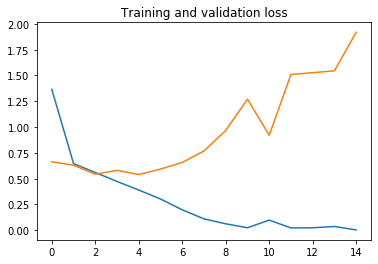

In [23]:
import matplotlib.pyplot as plt

# Get number of epochs
epochs = range(len(epoch_train_acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, epoch_train_acc)
plt.plot(epochs, epoch_valid_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, epoch_train_loss)
plt.plot(epochs, epoch_valid_loss)
plt.title('Training and validation loss')

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)